# The Metropolitan Museum of Art: Open Access

### Kate Stadelman
### Tools One Final Project, Winter 2022

In [1]:
from ast import Assert
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import requests
import seaborn as sns
import scipy.stats as ss
import shap
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import RobustScaler

%matplotlib inline

In [ ]:
![The Metropolitan Museum of Art](met_art.png 'The Met')

## Dataset & Motivation
How/why the dataset was collected and a description of the metadata of your dataset.



Actual task definition/research question
What real-world problem are you trying to solve? What are the input and output of your analysis?

## Open Access Dataset

Stuff here

In [2]:
# enforce a specific commit (cc6310135aeafd01fb03588929fb9d00c5cbc606) from Jan 17, 2022 
# because data is manually input with no tagged releases
sources = {
    'license': {
        'url': 'https://raw.githubusercontent.com/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/',
        'file': 'LICENSE'
    },
    'readme': { 
        'url': 'https://raw.githubusercontent.com/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/', 
        'file': 'README.md' 
    }, 
    'data': { 
        'url': 'https://media.githubusercontent.com/media/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/', 
        'file': 'MetObjects.csv',
        'checksum': '68d26f76485ccd066d45b6044d0954f1508e431a21c4ef7133f45c46931d4773' 
    }
}

In [3]:
# define where you want the data to live and mkdir if necessary
data_path = os.path.join(os.getcwd(), 'data', '')
if not os.path.exists(data_path):
    os.mkdir(data_path)

In [ ]:
def get_data(source, outpath):
    # get data and output to file
    try:
        r = requests.get(source['url'] + source['file'])
        r.raise_for_status()
        r.encoding = 'UTF-8'
        with open(outpath + source['file'], 'w') as f:
            f.write(r.text)
    except requests.exceptions.RequestException as e:
        print('Requests Error:', e)

    # validate data file
    if 'checksum' in source:
        try:
            with open(outpath + source['file'],"rb") as f:
                bytes = f.read()                                        # read entire file in as bytes
                readable_hash = hashlib.sha256(bytes).hexdigest()
            assert source['checksum'] == readable_hash                  # compare SHA256 hash
        except AssertionError:
            print('SHA256 Error:', source['checksum'], readable_hash)  

# download data
for source in sources:
    get_data(source=sources[source], outpath=data_path)

In [4]:
# load dirty data to dataframe
df = pd.read_csv(data_path + sources['data']['file'], sep=',', index_col=4, low_memory=False)

In [5]:
df.sample(5)

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
Object ID,,,,,,,,,,,,,,,,,,,,,
173940,2009.300.6920,False,False,True,NaN,Costume Institute,2009,Trousers,Trousers,American,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
286947,2005.100.373.48,False,False,True,NaN,Photographs,2005,Photograph,"Jérusalem, Vallée de Josaphat, Fronton du Tomb...",NaN,...,NaN,Photographs,NaN,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",Architecture,http://vocab.getty.edu/page/aat/300263552,https://www.wikidata.org/wiki/Q12271
554949,30.6.63,False,False,True,117,Egyptian Art,1930,"Cone, Amenemhat, circular impression, scribe, ...",Funerary Cone of the Steward of the Vizier Ame...,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",Hieroglyphs,http://vocab.getty.edu/page/aat/300028721,https://www.wikidata.org/wiki/Q193762
239596,74.51.11,False,False,True,NaN,Greek and Roman Art,1874,Bead,Glass bead,Cypriot,...,NaN,Glass,NaN,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
451391,57.51.8,False,False,True,NaN,Islamic Art,1957,Folio from an illustrated manuscript,"""Bahman Taking Revenge on the Sistanians"" Fol...",NaN,...,NaN,Codices,NaN,http://www.metmuseum.org/art/collection/search...,NaN,NaN,"Metropolitan Museum of Art, New York, NY",Men|Horse Riding,http://vocab.getty.edu/page/aat/300025928|http...,https://www.wikidata.org/wiki/Q8441|https://ww...


## Literature Review

https://medium.com/towards-data-science/metropolitan-museum-of-art-data-analysis-and-visualization-7d1d023c68fe

In [ ]:
top_artists = df[['Artist Display Name', 'Object Number']].groupby('Artist Display Name')['Object Number'].count()
top_artists = top_artists.rename_axis('Artist Display Name').reset_index()
top_artists = top_artists.rename(columns={'Object Number':'Artworks'})
top_artists = top_artists.sort_values(by='Artworks', ascending=False).head(10)
top_cultures = df[['Culture', 'Object Number']].groupby('Culture')['Object Number'].count()
top_cultures = top_cultures.rename_axis('Culture').reset_index()
top_cultures = top_cultures.rename(columns={'Object Number':'Artworks'})
top_cultures = top_cultures.sort_values(by='Artworks', ascending=False).head(10)

fig, axes = plt.subplots(1,1,figsize=(15,7))
fig.set_facecolor('white')
sns.set_palette('mako')
sns.barplot(x='Artworks', y='Artist Display Name', data=top_artists, ax=axes[0],palette=sns.color_palette('crest',10))
axes[0].set_title('Top 10 Artists', fontsize=15)
data = top_cultures['Artworks']
labels = top_cultures['Culture']
colors = sns.color_palette('crest')[0:10]
plt.pie(x=data, labels=labels, colors=colors, autopct="%.1f%%", pctdistance=0.5, ax=axes[1])
axes[1].set_title('Top 10 Cultures', fontsize=15);
plt.show()


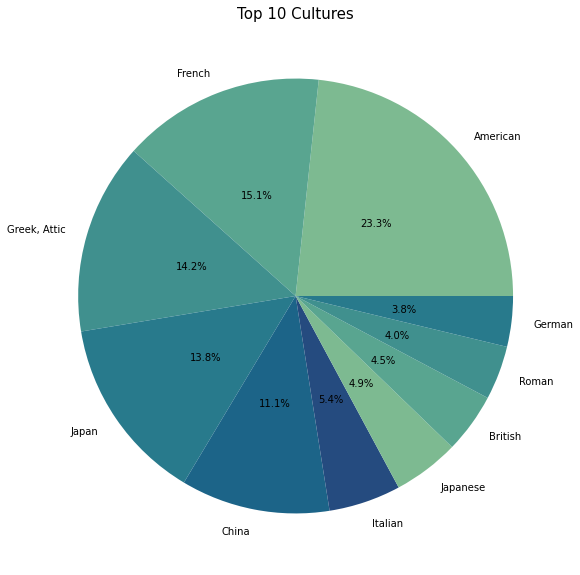

In [10]:

fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
data = top_cultures['Artworks']
labels = top_cultures['Culture']
colors = sns.color_palette('crest')[0:10]
plt.pie(x=data, labels=labels, colors=colors, autopct="%.1f%%", pctdistance=0.5)
plt.title('Top 10 Cultures', fontsize=15);
plt.show()

In [11]:
nans_df = pd.DataFrame(df.isna().mean().mul(100).round(), columns=['Percent NaN'])
nans_df['Unique Values'] = df.nunique()
nans_df = nans_df.rename_axis('Attribute').reset_index()
nans_df.sort_values(by=['Percent NaN'], inplace=True)

# removing columns that we would not consider using as features
nans_df = nans_df[(nans_df['Attribute']!='Object Number') & (nans_df['Attribute']!='Link Resource')
                  & (nans_df['Attribute']!='Title') & (nans_df['Attribute']!='Dimensions')]

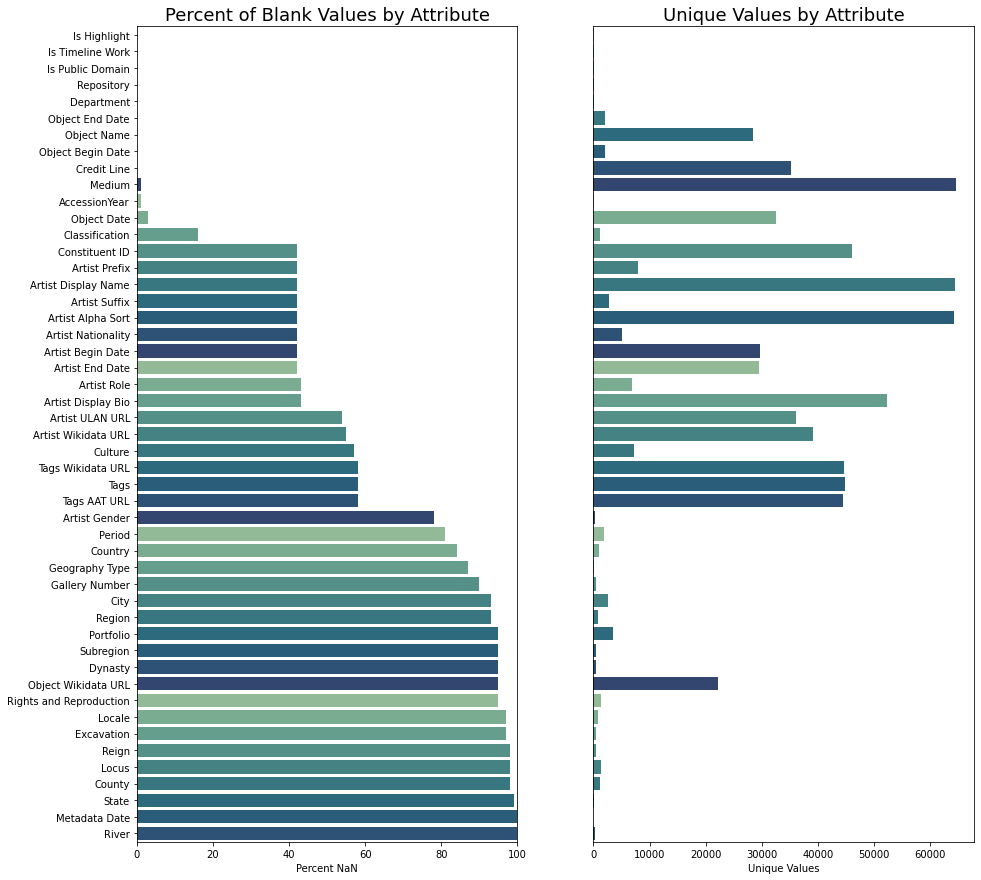

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))
sns.barplot(x='Percent NaN', y='Attribute', data=nans_df, ax=axes[0], palette=sns.color_palette('crest',10))
axes[0].set_xlim(0,100)
axes[0].set_title('Percent of Blank Values by Attribute', fontsize=18)
axes[0].set(ylabel=None)
sns.barplot(x='Unique Values', y='Attribute', data=nans_df, ax=axes[1], palette=sns.color_palette('crest',10))
axes[1].set_title('Unique Values by Attribute', fontsize=18)
axes[1].set(ylabel=None)
axes[1].set_yticks([])
plt.show()

No good region data, but can use Department as a proxy. Too many entries for artist and credit line to be useful.

In [13]:
# too many artists to use as a categorical variable
print('Number of Unique Artists:', df['Artist Display Name'].nunique())
print('Number of Unique Artists with Highlight Works:', df['Artist Display Name'][df['Is Highlight'] == True].nunique())

# too many credit lines to use as a categorical variable
print('Number of Unique Credit Lines:', df['Credit Line'].nunique())
print('Number of Unique Credit Lines with Highlight Works:', df['Credit Line'][df['Is Highlight'] == True].nunique())

Number of Unique Artists: 64330
Number of Unique Artists with Highlight Works: 1328
Number of Unique Credit Lines: 35247
Number of Unique Credit Lines with Highlight Works: 1421


Talk about measures

In [14]:
# begin our dataframe with 'best' data
met_df = df[['Department','Is Highlight','Is Timeline Work']].copy()                              # Department, Is Highlight, & Is Timeline Work look good
met_df['Is Displayed'] = df['Gallery Number'].apply(lambda x: False if x == np.nan else True)    # consider art displayed if it has a gallery number
print(met_df.shape)

(477202, 4)


In [15]:
# accession year
met_df['Accession Year'] = df['AccessionYear'].apply(lambda x: str(x)[0:4] if isinstance(x, str) else x)      # accession year is sometimes YYYY-MM-DD
met_df['Credit Line'] = df['Credit Line']
met_df['Credit Line Year'] = met_df['Credit Line'].str.extract(r'(\d{4})', expand = True)          # credit line sometimes has embedded accession year
met_df['Accession Year'].fillna(met_df['Credit Line Year'], inplace=True)
met_df.drop(columns=['Credit Line','Credit Line Year'], inplace=True)
met_df.dropna(inplace=True)
met_df['Accession Year'] = met_df['Accession Year'].astype(int)
print(met_df.shape)

(474280, 5)


In [16]:
# object year
df['Object Begin Date'] = df['Object Begin Date'].astype(int)
df['Object End Date'] = df['Object End Date'].astype(int)

met_df['Object Year'] = df['Object Begin Date']                                       # after close review, begin year more closely reflects object date col
met_df = met_df.loc[(df['Object Begin Date']!=0) & (df['Object End Date']!=0) & (df['Object Begin Date']<=df['Object End Date'])]         
met_df['Object Year'] = met_df['Object Year'].astype(int)
print(met_df.shape)

(472901, 6)


In [17]:
# classifications
print('Percent of Blank Classifications:', round((df['Classification'].isnull().sum()/df.shape[0])*100,2))
print('Number of Unique Classifications:', df['Classification'].nunique())

met_df = met_df.loc[~df['Classification'].isna()]

Percent of Blank Classifications: 16.38
Number of Unique Classifications: 1205


In [18]:
# too many credit lines to use as a categorical variable
classifications = [ 'Print', 'Textile', 'Photograph', 'Drawing', 'Vase', 'Book', 'Ceramic', 'Metal', 'Painting', 'Glass', 'Negative', 'Sculpture', 'Sword',
                   'Stone', 'Wood', 'Jewelry']

met_df['Classification'] = df['Classification'].apply(lambda x: [ i for i in classifications if i in str(x) ])
met_df['Classification'] = met_df['Classification'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [19]:
print('Percent of Non-Blank Classifications Belonging to Top', len(classifications), 'Classifications',
      round((met_df['Classification'].value_counts().sum()/met_df.shape[0])*100,2))

Percent of Non-Blank Classifications Belonging to Top 16 Classifications 87.38


In [20]:
met_df.dropna(inplace=True)
met_df['Department'] = met_df['Department'].astype('category')
met_df['Classification'] = met_df['Classification'].astype('category')

## Exploratory Data Analysis

In [23]:
met_df.sample(5)

,Department,Is Highlight,Is Timeline Work,Is Displayed,Accession Year,Object Year,Classification
Object ID,,,,,,,
821329,Drawings and Prints,False,False,True,1926,1864,Print
363522,Drawings and Prints,False,False,True,1967,1825,Drawing
254934,Greek and Roman Art,False,True,True,1957,1,Sculpture
326424,Ancient Near Eastern Art,False,False,True,1986,400,Stone
451890,Islamic Art,False,False,True,1967,1100,Ceramic


In [22]:
met_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345844 entries, 5209 to 857173
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Department        345844 non-null  category
 1   Is Highlight      345844 non-null  bool    
 2   Is Timeline Work  345844 non-null  bool    
 3   Is Displayed      345844 non-null  bool    
 4   Accession Year    345844 non-null  int64   
 5   Object Year       345844 non-null  int64   
 6   Classification    345844 non-null  category
dtypes: bool(3), category(2), int64(2)
memory usage: 9.6 MB


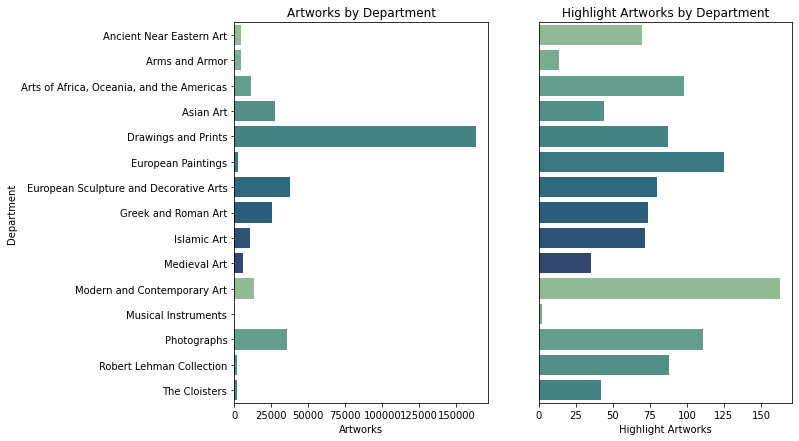

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10,7))
sns.countplot(y='Department', data=met_df, ax=axes[0], palette=sns.color_palette('crest',10))
axes[0].set_title('Artworks by Department', fontsize=12)
axes[0].set(xlabel='Artworks')
sns.countplot(y='Department', data=met_df[met_df['Is Highlight']==True], ax=axes[1], palette=sns.color_palette('crest',10))
axes[1].set_title('Highlight Artworks by Department', fontsize=12)
axes[1].set(xlabel='Highlight Artworks')
axes[1].set(ylabel=None)
axes[1].set_yticks([])
plt.show()

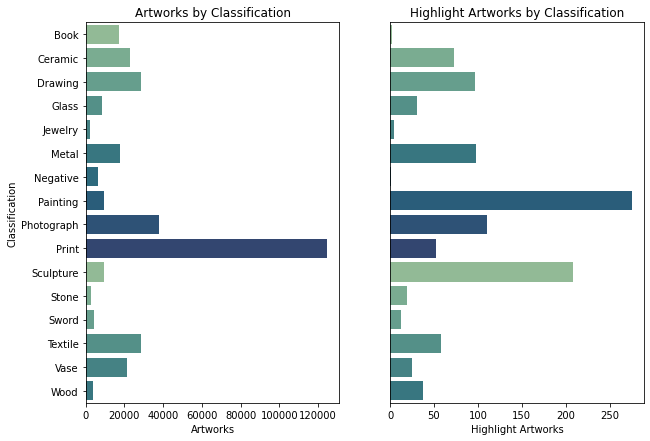

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10,7))
sns.countplot(y='Classification', data=met_df, ax=axes[0], palette=sns.color_palette('crest',10))
axes[0].set_title('Artworks by Classification', fontsize=12)
axes[0].set(xlabel='Artworks')
sns.countplot(y='Classification', data=met_df[met_df['Is Highlight']==True], ax=axes[1], palette=sns.color_palette('crest',10))
axes[1].set_title('Highlight Artworks by Classification', fontsize=12)
axes[1].set(xlabel='Highlight Artworks')
axes[1].set(ylabel=None)
axes[1].set_yticks([])
plt.show()

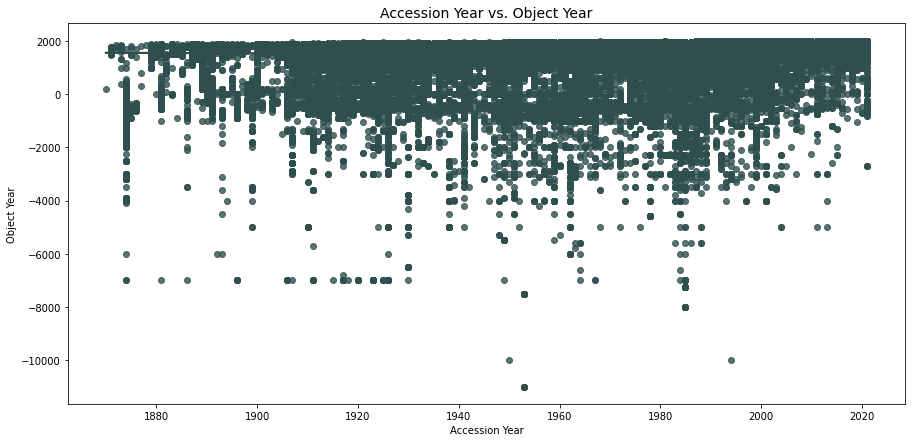

In [26]:
fig = plt.figure(figsize=(15,7))
ax = sns.regplot(x='Accession Year', y='Object Year', data=met_df, color='darkslategrey')
ax.set_title('Accession Year vs. Object Year', fontsize=14)
ax.set_xlabel('Accession Year')
ax.set_ylabel('Object Year')
plt.show()

In [27]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [29]:
dpt_cl_cm = pd.crosstab(met_df['Department'], met_df['Classification'])
print('Cramér\'s V between Department & Classification:', cramers_v(dpt_cl_cm.values))

Cramér's V between Survived & Title: 0.5431585108922641


In [32]:
ht_cm = pd.crosstab(met_df['Is Highlight'], met_df['Is Timeline Work'])
print('Cramér\'s V between Highlight & Timeline Work:', cramers_v(ht_cm.values))

Cramér's V between Highlight & Timeline Work: 0.3118106577227118


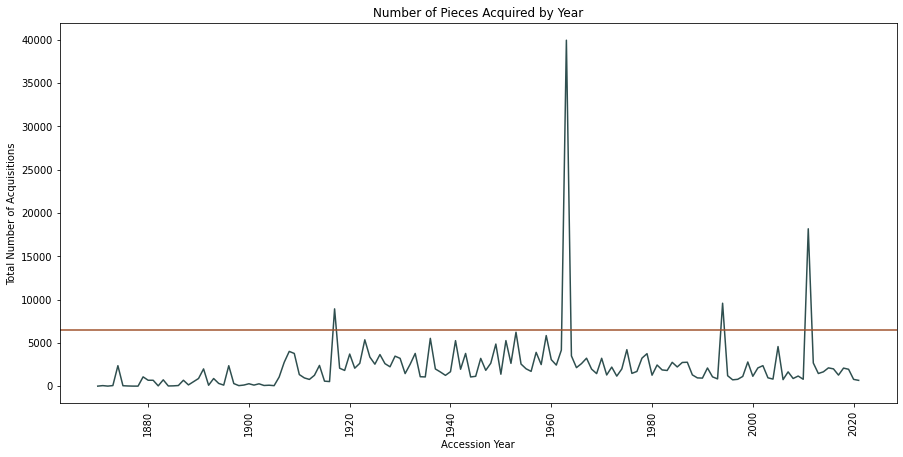

In [33]:
acc_yr = met_df.groupby(['Accession Year'])['Department'].count()
acc_yr = acc_yr.rename_axis('Accession Year').reset_index()
acc_yr = acc_yr.rename(columns={'Department':'Count'})

fig = plt.figure(figsize=(15,7))
ax = sns.lineplot(x='Accession Year', y='Count', data=acc_yr, color='darkslategrey')
ax.set(title='Number of Pieces Acquired by Year', xlabel='Accession Year', ylabel='Total Number of Acquisitions')
plt.xticks(rotation = 90)
plt.axhline(6500, color='sienna')
plt.show()

In [34]:
acc_yr.sort_values(by='Count', ascending=False).head(10)

,Accession Year,Count
93,1963,39953
141,2011,18173
124,1994,9576
47,1917,8925
83,1953,6228
89,1959,5839
66,1936,5518
53,1923,5352
81,1951,5258
71,1941,5254


# Acquisition Outliers

### The Jefferson R. Burdick Collection

https://www.metmuseum.org/about-the-met/collection-areas/drawings-and-prints/burdick-collection

In [35]:
credit_line_1963 = df[df['AccessionYear']=='1963'].groupby('Credit Line')['Object Number'].count()
print(credit_line_1963.sort_values(ascending=False).head(1))

Credit Line
The Jefferson R. Burdick Collection, Gift of Jefferson R. Burdick    37118
Name: Object Number, dtype: int64


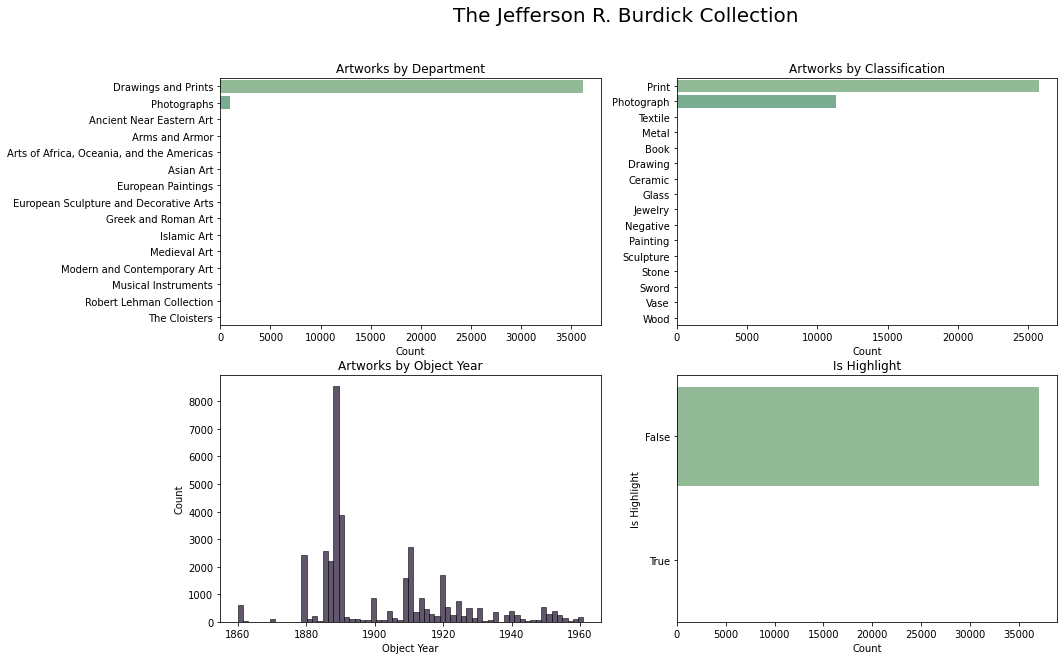

In [36]:
burdick = met_df.loc[(met_df['Accession Year']==1963) & (df['Credit Line']=='The Jefferson R. Burdick Collection, Gift of Jefferson R. Burdick')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=burdick, order=burdick['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=burdick, order=burdick['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=burdick, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=burdick, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The Jefferson R. Burdick Collection', fontsize=20)
plt.show()

### The Dietrich von Bothmer Fragment Collection

https://www.metmuseum.org/about-the-met/collection-areas/greek-and-roman-art/bothmer-fragment-collection

In [37]:
credit_line_2011 = df[df['AccessionYear']=='2011'].groupby('Credit Line')['Object Number'].count()
print(credit_line_2011.sort_values(ascending=False).head(1))

Credit Line
Gift of Dietrich von Bothmer, Distinguished Research Curator, Greek and Roman Art, 2011    16270
Name: Object Number, dtype: int64


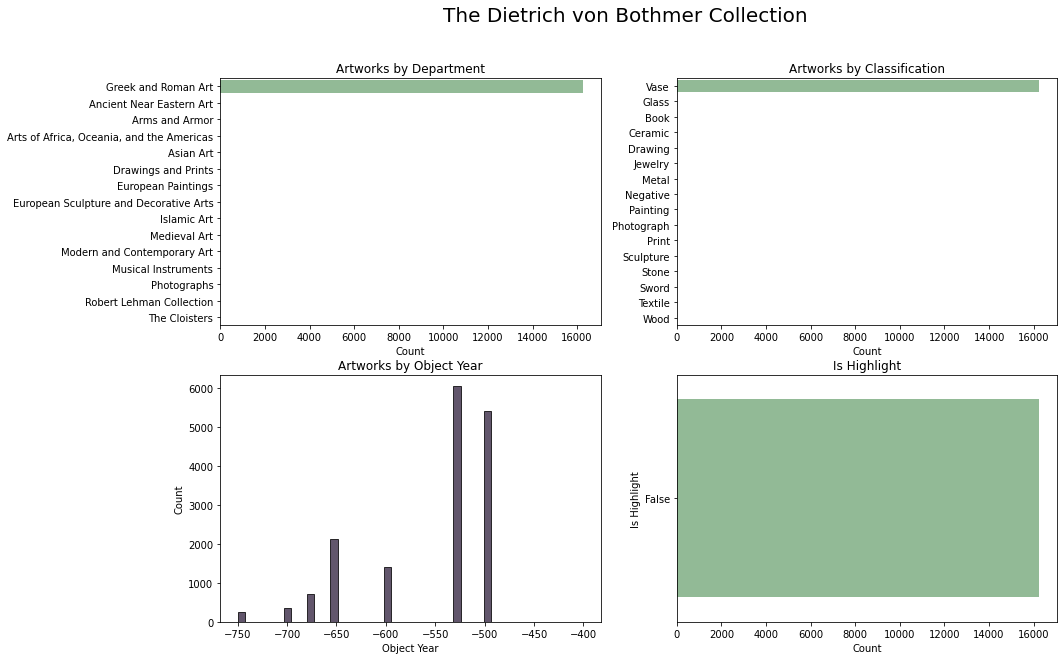

In [38]:
bothmer = met_df.loc[(met_df['Accession Year']==2011) & 
                     (df['Credit Line']=='Gift of Dietrich von Bothmer, Distinguished Research Curator, Greek and Roman Art, 2011')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=bothmer, order=bothmer['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=bothmer, order=bothmer['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=bothmer[bothmer['Object Year']<=-400], ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=bothmer, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The Dietrich von Bothmer Collection', fontsize=20)
plt.show()

### The Walker Evans Archive

https://www.metmuseum.org/press/exhibitions/1999/the-metropolitan-museum-of-art-opens-walker-evans-archive-on-february-1

In [39]:
credit_line_1994 = df[df['AccessionYear']=='1994'].groupby('Credit Line')['Object Number'].count()
print(credit_line_1994.sort_values(ascending=False).head(1))

Credit Line
Walker Evans Archive, 1994    7942
Name: Object Number, dtype: int64


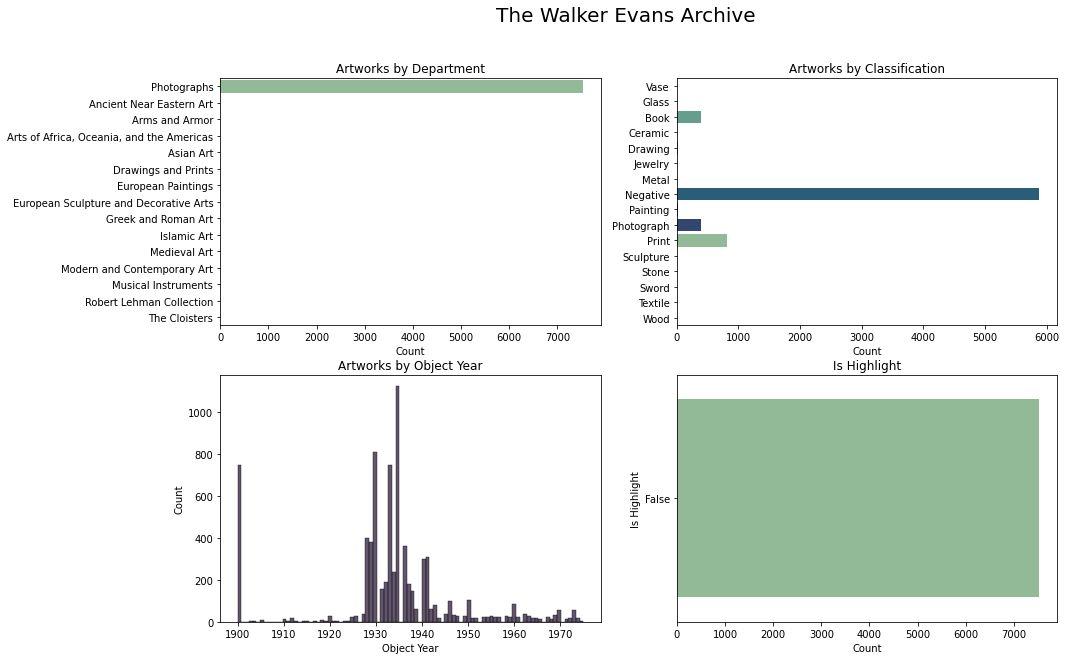

In [40]:
evans = met_df.loc[(met_df['Accession Year']==1994) & 
                     (df['Credit Line']=='Walker Evans Archive, 1994')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=evans, order=evans['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=evans, order=bothmer['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=evans[evans['Object Year']>=1900], ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=evans, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The Walker Evans Archive', fontsize=20)
plt.show()

In [41]:
credit_line_1917 = df[df['AccessionYear']=='1917'].groupby('Credit Line')['Object Number'].count()
print(credit_line_1917.sort_values(ascending=False).head(1))

Credit Line
Gift of J. Pierpont Morgan, 1917    4571
Name: Object Number, dtype: int64


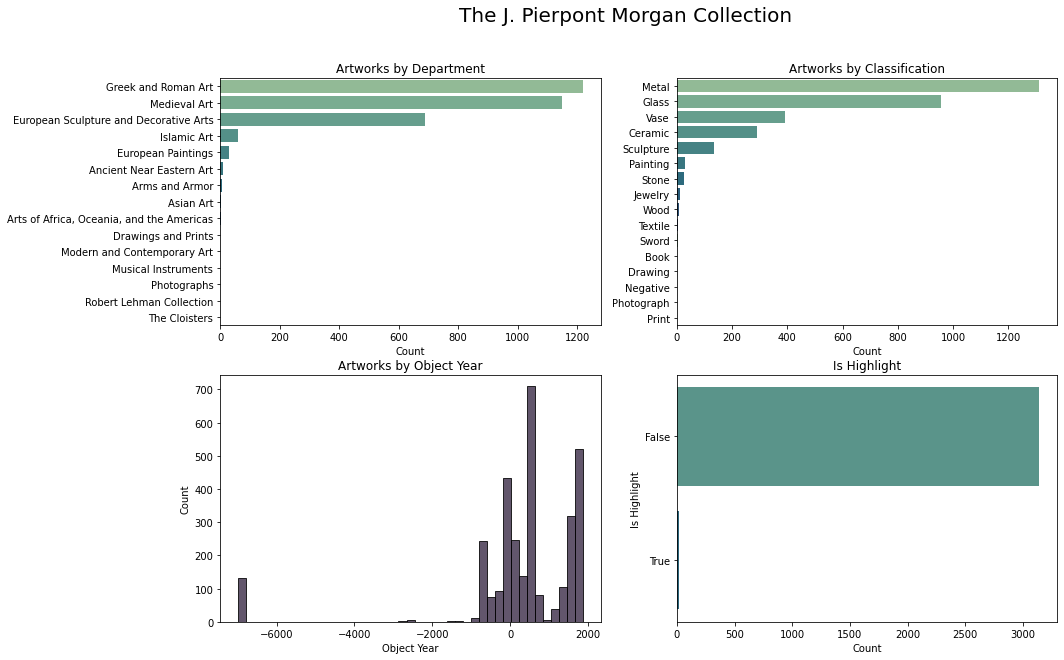

In [42]:
morgan = met_df.loc[(met_df['Accession Year']==1917) & 
                     (df['Credit Line']=='Gift of J. Pierpont Morgan, 1917')]

fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(y='Department', data=morgan, order=morgan['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=morgan, order=morgan['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=morgan, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.countplot(y='Is Highlight', data=morgan, ax=axes[1,1], palette=sns.color_palette('crest',2))
axes[1,1].set_title('Is Highlight', fontsize=12)
axes[1,1].set(xlabel='Count')
plt.suptitle('The J. Pierpont Morgan Collection', fontsize=20)
plt.show()

## Final Dataset

test

In [43]:
met = met_df[met_df['Is Displayed'] == True].copy()
met = met.loc[ (df['Credit Line'] != 'The Jefferson R. Burdick Collection, Gift of Jefferson R. Burdick') &
               (df['Credit Line'] != 'Gift of Dietrich von Bothmer, Distinguished Research Curator, Greek and Roman Art, 2011') &
               (df['Credit Line'] != 'Walker Evans Archive, 1994') & (df['Credit Line'] != 'Gift of J. Pierpont Morgan, 1917') ]
met.shape

(281790, 7)

In [44]:
met.sample(5)

,Department,Is Highlight,Is Timeline Work,Is Displayed,Accession Year,Object Year,Classification
Object ID,,,,,,,
259148,Greek and Roman Art,False,False,True,2011,-575,Vase
262468,Photographs,False,False,True,1978,1860,Photograph
631295,Drawings and Prints,False,False,True,1953,1562,Print
647500,Drawings and Prints,False,False,True,1951,1664,Print
626515,Drawings and Prints,False,False,True,1926,1776,Print


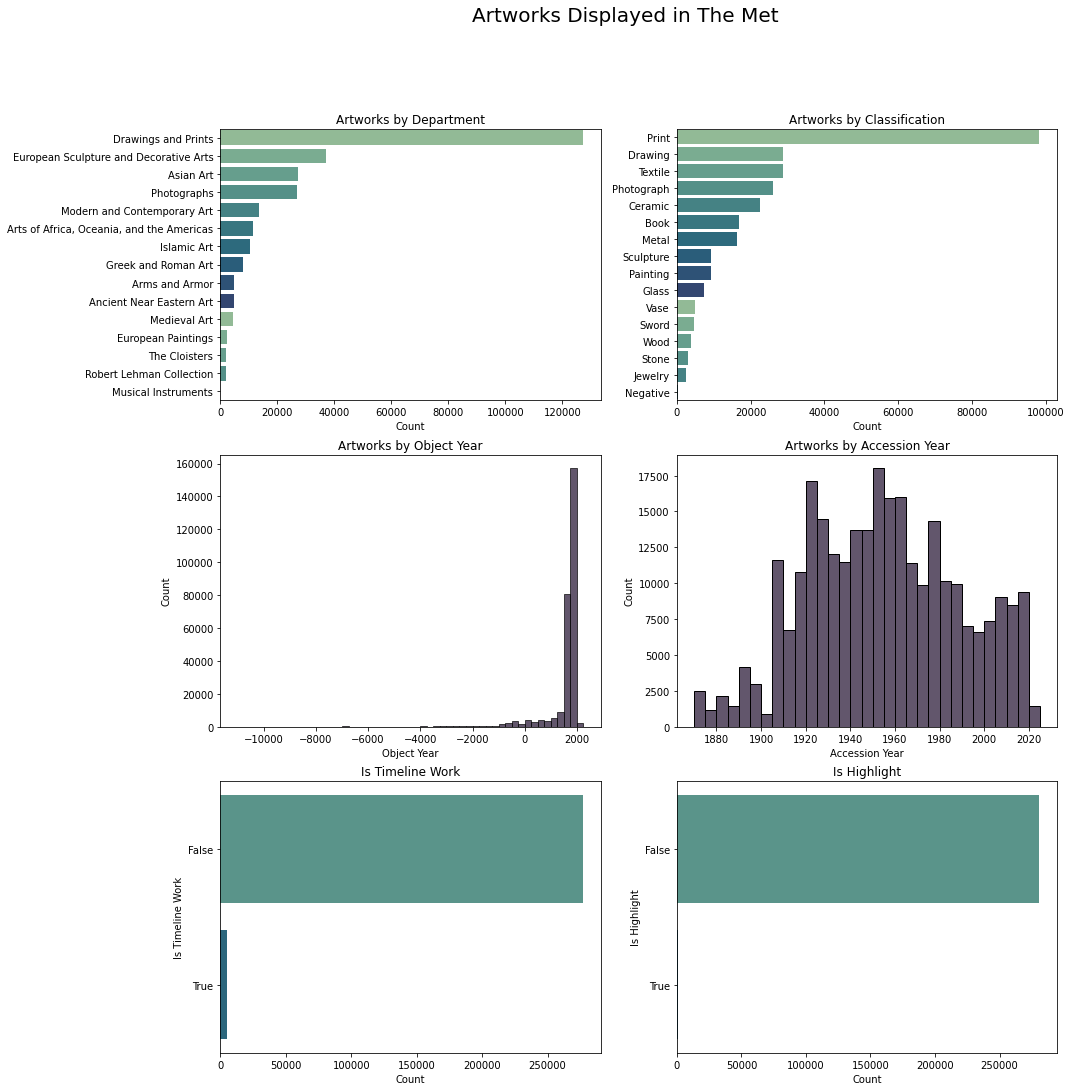

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(15,17))
sns.countplot(y='Department', data=met, order=met['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=met, order=met['Classification'].value_counts().index, ax=axes[0,1], palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=met, binwidth=250, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.histplot(x='Accession Year', data=met, binwidth=5, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Artworks by Accession Year', fontsize=12)
axes[1,1].set(ylabel='Count')
sns.countplot(y='Is Timeline Work', data=met, ax=axes[2,0], palette=sns.color_palette('crest',2))
axes[2,0].set_title('Is Timeline Work', fontsize=12)
axes[2,0].set(xlabel='Count')
sns.countplot(y='Is Highlight', data=met, ax=axes[2,1], palette=sns.color_palette('crest',2))
axes[2,1].set_title('Is Highlight', fontsize=12)
axes[2,1].set(xlabel='Count')
plt.suptitle('Artworks Displayed in The Met', fontsize=20)
plt.show()

### Highlight Artworks Data Mining

In [46]:
met_highlight = met[met['Is Highlight'] == True]

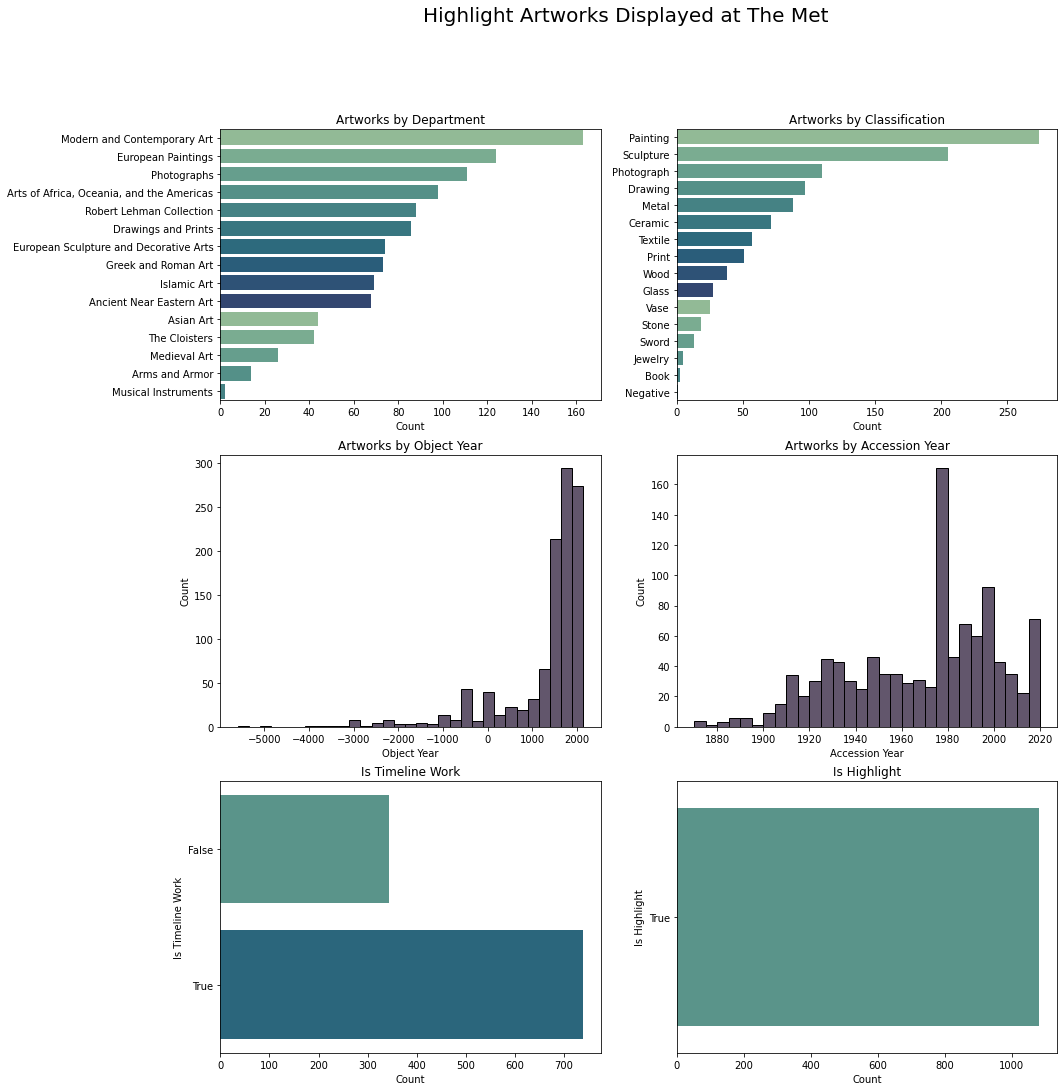

In [47]:
fig, axes = plt.subplots(3, 2, figsize=(15,17))
sns.countplot(y='Department', data=met_highlight, order=met_highlight['Department'].value_counts().index, ax=axes[0,0], palette=sns.color_palette('crest',10))
axes[0,0].set_title('Artworks by Department', fontsize=12)
axes[0,0].set(xlabel='Count')
axes[0,0].set(ylabel=None)
sns.countplot(y='Classification', data=met_highlight, order=met_highlight['Classification'].value_counts().index, ax=axes[0,1],
              palette=sns.color_palette('crest',10))
axes[0,1].set_title('Artworks by Classification', fontsize=12)
axes[0,1].set(xlabel='Count')
axes[0,1].set(ylabel=None)
sns.histplot(x='Object Year', data=met_highlight, binwidth=250, ax=axes[1,0], palette=sns.color_palette('crest',10))
axes[1,0].set_title('Artworks by Object Year', fontsize=12)
axes[1,0].set(ylabel='Count')
sns.histplot(x='Accession Year', data=met_highlight, binwidth=5, ax=axes[1,1], palette=sns.color_palette('crest',10))
axes[1,1].set_title('Artworks by Accession Year', fontsize=12)
axes[1,1].set(ylabel='Count')
sns.countplot(y='Is Timeline Work', data=met_highlight, ax=axes[2,0], palette=sns.color_palette('crest',2))
axes[2,0].set_title('Is Timeline Work', fontsize=12)
axes[2,0].set(xlabel='Count')
sns.countplot(y='Is Highlight', data=met_highlight, ax=axes[2,1], palette=sns.color_palette('crest',2))
axes[2,1].set_title('Is Highlight', fontsize=12)
axes[2,1].set(xlabel='Count')
plt.suptitle('Highlight Artworks Displayed at The Met', fontsize=20)
plt.show()

In [49]:
onehot_df = met.copy()
onehot_df['Is Highlight'] = onehot_df['Is Highlight'].apply(lambda x: 1 if x == True else 0)
onehot_df['Is Timeline Work'] = onehot_df['Is Timeline Work'].apply(lambda x: 1 if x == True else 0)
onehot_df.drop(columns=['Is Displayed'], inplace=True)
onehot = pd.get_dummies(onehot_df, columns=['Department','Classification'])
onehot.sample(5)

,Is Highlight,Is Timeline Work,Accession Year,Object Year,Department_Ancient Near Eastern Art,Department_Arms and Armor,"Department_Arts of Africa, Oceania, and the Americas",Department_Asian Art,Department_Drawings and Prints,Department_European Paintings,...,Classification_Negative,Classification_Painting,Classification_Photograph,Classification_Print,Classification_Sculpture,Classification_Stone,Classification_Sword,Classification_Textile,Classification_Vase,Classification_Wood
Object ID,,,,,,,,,,,,,,,,,,,,,
495617,0,0,2008,1980,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700368,0,0,1959,1533,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
777526,0,0,2011,1961,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
391973,0,0,1967,1927,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
715655,0,0,1929,1919,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [50]:
# articles say scaling years for random forest not necessary
features = onehot.columns[1:]
X = onehot[onehot.columns[1:]].to_numpy()
y = onehot['Is Highlight'].to_numpy()

In [ ]:
# get random forest paramenters
clf = RandomForestClassifier()
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 50, 100, 200],
                 'max_features': [2, 3, 4, 5, 7, 10, 15]
             }
grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X, y)

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

# commenting this out for final report because it takes quite a while to run
# RandomForestClassifier(max_depth=2, n_estimators=10)
# {'max_depth': 2, 'n_estimators': 10}

In [65]:
rf = RandomForestClassifier(n_estimators=100, max_features=5)
rf.fit(X, y)
y_rf = rf.predict(X)


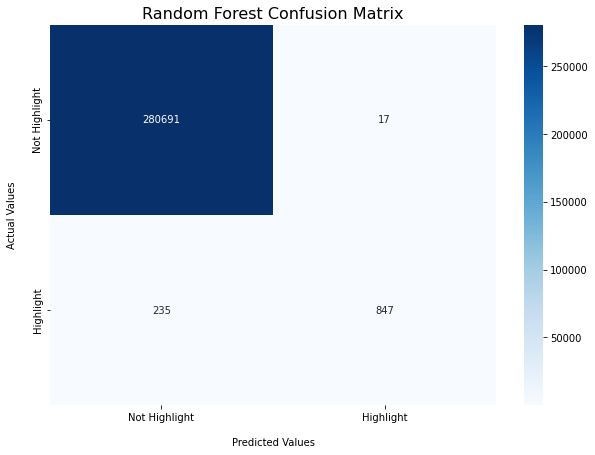

In [66]:
rf_cm = confusion_matrix(y, y_rf)

fig = plt.figure(figsize = (10,7))
ax = sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt='g')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n')
ax.xaxis.set_ticklabels(['Not Highlight','Highlight'])
ax.yaxis.set_ticklabels(['Not Highlight','Highlight'])
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.show()

In [64]:
print('Random Forest Classification Report\n\n')
print(classification_report(y, y_rf, target_names=['Not Highlight','Highlight']))

Random Forest Classification Report


               precision    recall  f1-score   support

Not Highlight       1.00      1.00      1.00    280708
    Highlight       0.97      0.79      0.87      1082

     accuracy                           1.00    281790
    macro avg       0.99      0.89      0.94    281790
 weighted avg       1.00      1.00      1.00    281790



In [ ]:
# shap values to find important features
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X, approximate=True)

In [ ]:
fig = plt.figure(figsize=(15,7))
shap.summary_plot(rf_shap_values, features=X, feature_names=features, plot_type='bar', show=False)
plt.title('Random Forest SHAP Values', fontsize=16)
plt.show()

In [ ]:
fig = plt.figure(figsize=(25, 35))
plot_tree(rf.estimators_[0], 
          feature_names=features,
          class_names=['Not Highlight','Highlight'],
          filled=True, 
          impurity=True, 
          rounded=True,
          fontsize=10)
plt.title('Random Forest Decision Tree', fontsize=16)
plt.show()